In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lib.fit_model_on_multiple import fit_lr, predict_lr, fit_rf, plot_md_vs_rmsd, predict_rf
from pathlib import Path
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pathlib import Path
from scipy.stats import linregress

In [59]:
length = 800
mds = []
rmsds = []

da = DihedralAdherence(
    'T1024', [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='ml',
    weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda'
)
da.load_results_da()
da.grouped_preds_da['rmsd'] = da.grouped_preds.set_index('protein_id')['RMS_CA']
rmsd = da.grouped_preds_da['rmsd']
md = da.grouped_preds_da.iloc[:,:-1].values
if md.shape[1] < length:
    md = np.concatenate([md, np.zeros((md.shape[0], length-md.shape[1]))], axis=1)
if md.shape[1] > length:
    md = md[:,:length]

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
(484, 800)


In [10]:
PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR = 'casp_da'
proteins = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
mds = []
rmsds = []
preds = []
for protein in proteins:
    length = 800
    da = DihedralAdherence(
        protein, [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='ml',
        weights_file='ml_data/best_model_kde_64-64_390.pt', device='cuda'
    )
    da.load_results_da()
    da.grouped_preds_da = da.grouped_preds_da.sort_index()
    da.grouped_preds = da.grouped_preds.sort_values('protein_id')
    da.grouped_preds_da['rmsd'] = da.grouped_preds.set_index('protein_id')['RMS_CA']
    rmsd = da.grouped_preds_da['rmsd']
    md = da.grouped_preds_da.iloc[:,:-1].values
    md[np.isnan(md)] = 0
    if md.shape[1] < length:
        md = np.concatenate([md, np.zeros((md.shape[0], length-md.shape[1]))], axis=1)
    if md.shape[1] > length:
        md = md[:,:length]
    print(md.shape)
    mds.append(md)
    rmsds.append(rmsd)
    preds.append(da.grouped_preds)

md = np.concatenate(mds)
rmsd = np.concatenate(rmsds)
preds_ = pd.concat(preds)

Initializing T1024 ...
Results already exist
Casp ID: T1024 	PDB: 6t1z
Structure exists: 'pdb/pdb6t1z.ent' 
Index([     3,      4,      5,      6,      7,      8,      9,     10,     11,
           12,
       ...
          396,    397,    398,    399,    400,    401,    402,    403,    404,
       'rmsd'],
      dtype='object', name='pos', length=403)
(484, 800)
Initializing T1096 ...
Results already exist
Casp ID: T1096 	PDB: 7um1
Structure exists: 'pdb/pdb7um1.ent' 
No AlphaFold prediction found for 7um1
No AlphaFold phi-psi data found
Index([     3,      4,      5,      6,      7,      8,      9,     10,     11,
           12,
       ...
          452,    453,    454,    455,    456,    457,    458,    459,    460,
       'rmsd'],
      dtype='object', name='pos', length=459)
(436, 800)
Initializing T1027 ...
Results already exist
Casp ID: T1027 	PDB: 7d2o
Structure exists: 'pdb/pdb7d2o.ent' 
Index([     3,      4,      5,      6,      7,      8,      9,     10,     11,
           1

In [127]:
lim = 70
X = md[rmsd < lim]
preds = preds_.iloc[rmsd < lim]
y = rmsd[rmsd < lim]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
preds['rms_pred'] = model.predict(X)
print(model.rsquared)
# grouped_preds['RMS_CA'] = y

0.8259795856782445


/tmp/ipykernel_3636935/2311107508.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds['rms_pred'] = model.predict(X)


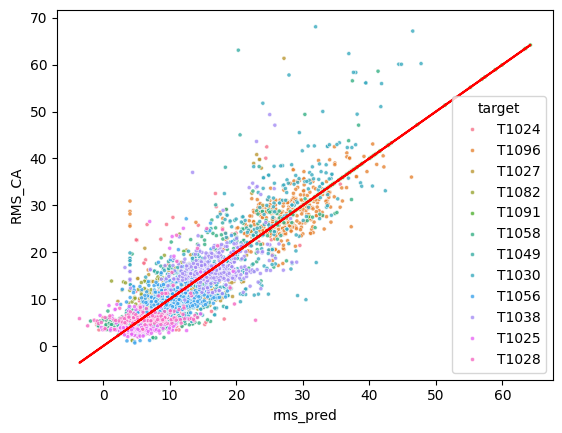

In [128]:
regr = linregress(preds.rms_pred, preds.RMS_CA)
sns.scatterplot(x='rms_pred', y='RMS_CA', data=preds, hue='target', marker='.', alpha=0.8)
plt.plot(preds.rms_pred, regr.intercept + regr.slope*preds.rms_pred, color='red')
plt.show()

Slope: 1.000000000000018, Intercept: 1.2789769243681803e-13


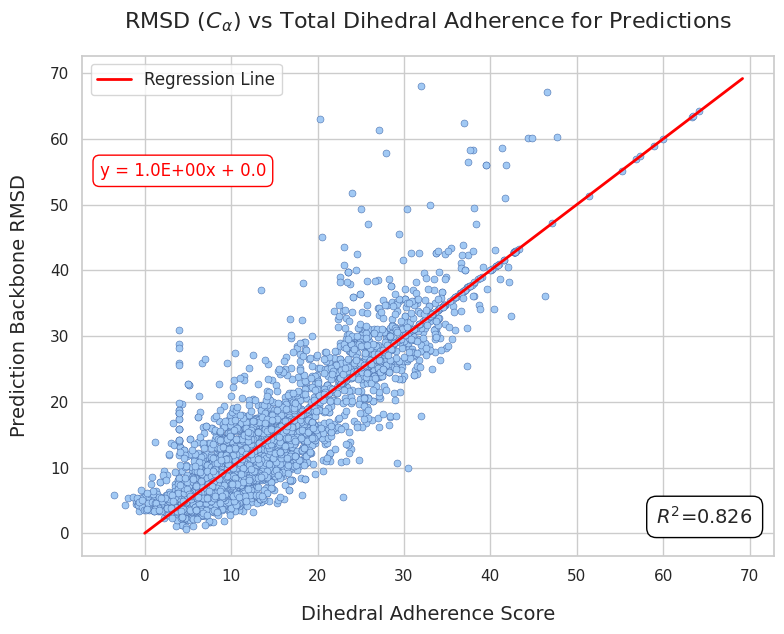

In [129]:
sns.set_theme(style="whitegrid")
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(8, 6.5))
regr = linregress(preds.rms_pred, preds.RMS_CA)
print(f'Slope: {regr.slope}, Intercept: {regr.intercept}')
sns.scatterplot(data=preds, x='rms_pred', y='RMS_CA', ax=ax, marker='o', s=25, edgecolor='b', legend=True)
ax.plot(
    np.linspace(0, preds.rms_pred.max() + 5, 100), 
    regr.intercept + regr.slope * np.linspace(0, preds.rms_pred.max() + 5, 100), 
    color='red', lw=2, label='Regression Line'
)

ax.set_xlabel('Dihedral Adherence Score', fontsize=14, labelpad=15)
ax.set_ylabel('Prediction Backbone RMSD', fontsize=14, labelpad=15)
ax.set_title(r'RMSD ($C_{\alpha}$) vs Total Dihedral Adherence for Predictions', fontsize=16, pad=20)
ax.text(0.83, 0.10, r'$R^2$='+f'{regr.rvalue**2:.3f}', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))
if regr.intercept > 0:
    s = f'y = {regr.slope:.1E}x + {regr.intercept:.1f}'
else:
    s = f'y = {regr.slope:.1E}x - {-regr.intercept:.1f}'
ax.text(.025,.76, s, transform=ax.transAxes, fontsize=12, color='red',
        bbox=dict(boxstyle='round,pad=0.4', edgecolor='red', facecolor='white'))
# ax.set_xlim(0, preds.da.max() + 5)
# ax.set_ylim(-0.5, preds.RMS_CA.max() + 5)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
sns.reset_defaults()

In [148]:
preds.da.isna().sum()

40

NameError: name 'preds' is not defined

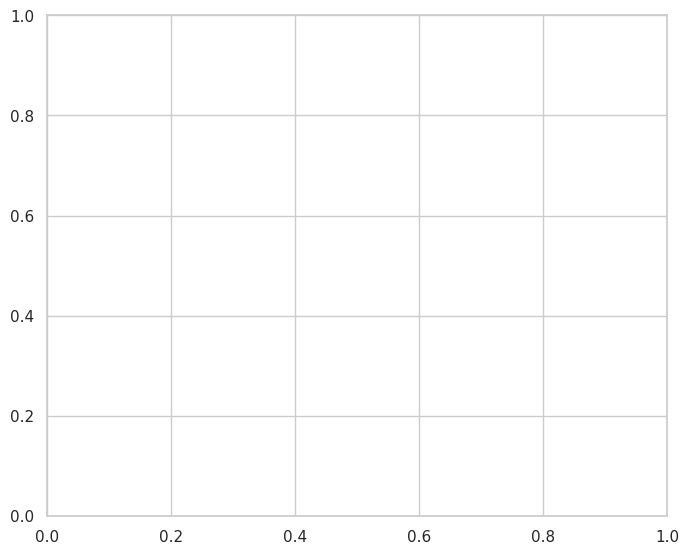

In [3]:
sns.set_theme(style="whitegrid")
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(8, 6.5))
df = preds.dropna(subset=['da', 'RMS_CA']).reset_index(drop=True)
# df = df[df.RMS_CA < 20]
regr = linregress(df.da, df.RMS_CA)
print(f'Slope: {regr.slope}, Intercept: {regr.intercept}')
# sns.kdeplot(data=df, x='da', y='RMS_CA', ax=ax, fill=True, bw_method=0.1)
sns.scatterplot(data=df, x='da', y='RMS_CA', ax=ax, marker='o', s=25, edgecolor='b', legend=True, hue='target')
sns.regplot(data=df.reset_index(drop=True), x='da', y='RMS_CA', ax=ax, scatter=False, color='red')
# ax.plot(
#     np.linspace(0, preds.da.max() + 5, 100), 
#     regr.intercept + regr.slope * np.linspace(0, preds.da.max() + 5, 100), 
#     color='red', lw=2, label='Regression Line'
# )

ax.set_xlabel('Dihedral Adherence Score', fontsize=14, labelpad=15)
ax.set_ylabel('Prediction Backbone RMSD', fontsize=14, labelpad=15)
ax.set_title(r'RMSD ($C_{\alpha}$) vs Total Dihedral Adherence for Predictions', fontsize=16, pad=20)
ax.text(0.83, 0.10, r'$R^2$='+f'{regr.rvalue**2:.3f}', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white'))
if regr.intercept > 0:
    s = f'y = {regr.slope:.1E}x + {regr.intercept:.1f}'
else:
    s = f'y = {regr.slope:.1E}x - {-regr.intercept:.1f}'
ax.text(.025,.76, s, transform=ax.transAxes, fontsize=12, color='red',
        bbox=dict(boxstyle='round,pad=0.4', edgecolor='red', facecolor='white'))
# ax.set_xlim(0, preds.da.max() + 5)
# ax.set_ylim(-0.5, preds.RMS_CA.max() + 5)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
sns.reset_defaults()